# Market Making and Optimal Quoting

## High-frequency trading in a limit order book (Avellanda & Stoikov 2008), The Seminal Paper

In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Constants for simulation
@dataclass
class Constants:
    ALPHA = 1.5   # used in order arrival intensity
    BETA = 0.6    # used in order arrival intensity
    SIGMA = 0.5   # volatility
    GAMMA = 0.1   # risk aversion coefficient
    K = 1.5       # market liquidity parameter
    A = 140       # market liquidity parameter

@dataclass
class StartConditions:
    PRICE_S = 100       # asset price t0
    INVENTORY_Q = 0       # inventory t0
    CASH_X = 1000     # cash t0

@dataclass
class TimeHorizon:
    FINAL_TIME = 1
    TIME_INCREMENT = 0.005  # time increment

In [39]:
@dataclass
class MarketMakerRun:
    asset_prices: np.ndarray
    reservation_prices: np.ndarray
    mm_bids: np.ndarray
    mm_asks: np.ndarray
    inventory_snapshots: np.ndarray
    cash_snapshots: np.ndarray
    portfolio_snapshots: np.ndarray

In [62]:
class MarketMaker:
    def __init__(self, arrival_intensity=0.5, arrival_amount=10):
        self.arrival_intensity = arrival_intensity
        self.arrival_amount = arrival_amount

    def get_marketmaker_quote(self, asset_price, inventory, timepoint):
        reservation_price = self.calc_reservation_price(asset_price, inventory, timepoint)
        spread = self.calc_spread(timepoint)
        bid = min(reservation_price - spread / 2, asset_price)
        ask = max(reservation_price + spread / 2, asset_price)
        return {'reservation_price': reservation_price, 'bid': bid, 'ask': ask}

    def calc_reservation_price(self, asset_price, inventory, timepoint):
        return (
            asset_price - inventory * Constants.GAMMA * Constants.SIGMA ** 2 \
            * (TimeHorizon.FINAL_TIME - timepoint)
        )

    def calc_spread(self, timepoint):
        return (
            Constants.GAMMA * Constants.SIGMA ** 2 \
            * (TimeHorizon.FINAL_TIME - timepoint) \
            + 2 / Constants.GAMMA \
            * np.log(1 + Constants.GAMMA / Constants.K)
        )

    def get_inventory_change(self, asset_price, inventory, cash):
        # simulate arriving orders that lift/hit Market Makers bids/asks
        buy_or_sell = np.random.rand()
        amount = np.random.rand() * self.arrival_amount
        if buy_or_sell >= self.arrival_intensity:
            # sell shares
            inventory -= amount
            cash += asset_price * amount
        else:
            inventory += amount
            cash -= asset_price * amount
        return inventory, cash

    def calc_order_intensity(self, spread):
        return Constants.A * np.exp(-Constants.K * spread)

    def get_random_asset_price(self, asset_price, dt=TimeHorizon.TIME_INCREMENT):
        increment = 4 * Constants.SIGMA * np.sqrt(dt)
        upper = asset_price + increment
        lower = asset_price - increment
        random_price = (upper - lower) * np.random.random() + lower
        return random_price

    def simulate_run(self):
        timesteps = np.arange(0, TimeHorizon.FINAL_TIME + TimeHorizon.TIME_INCREMENT, TimeHorizon.TIME_INCREMENT)
        asset_prices = np.empty_like(timesteps)
        reservation_prices = np.empty_like(timesteps)
        mm_bids = np.empty_like(timesteps)
        mm_asks = np.empty_like(timesteps)
        inventory_snapshots = np.empty_like(timesteps)
        cash_snapshots = np.empty_like(timesteps)
        portfolio_snapshots = np.empty_like(timesteps)

        for i in range(len(timesteps)):
            t = timesteps[i]
            if i == 0:
                asset_price = StartConditions.PRICE_S
                inventory = StartConditions.INVENTORY_Q
                cash = StartConditions.CASH_X
            else:
                asset_price = self.get_random_asset_price(asset_prices[i-1])
                inventory, cash = self.get_inventory_change(asset_price, inventory_snapshots[i-1], cash_snapshots[i-1])

            inventory_snapshots[i] = inventory
            cash_snapshots[i] = cash
            portfolio_snapshots[i] = cash + inventory * asset_price
            asset_prices[i] = asset_price
            
            mm_quote = self.get_marketmaker_quote(asset_price, inventory, t)
            reservation_prices[i] = mm_quote["reservation_price"]
            mm_bids[i] = mm_quote["bid"]
            mm_asks[i] = mm_quote["ask"]

        mm_run = MarketMakerRun(
            asset_prices=asset_prices,
            reservation_prices=reservation_prices,
            mm_bids=mm_bids,
            mm_asks=mm_asks,
            inventory_snapshots=inventory_snapshots,
            cash_snapshots=cash_snapshots,
            portfolio_snapshots=portfolio_snapshots,
        )
        return mm_run

In [63]:
mm = MarketMaker()
mm_run = mm.simulate_run()

Text(0.5, 1.0, 'Portfolio')

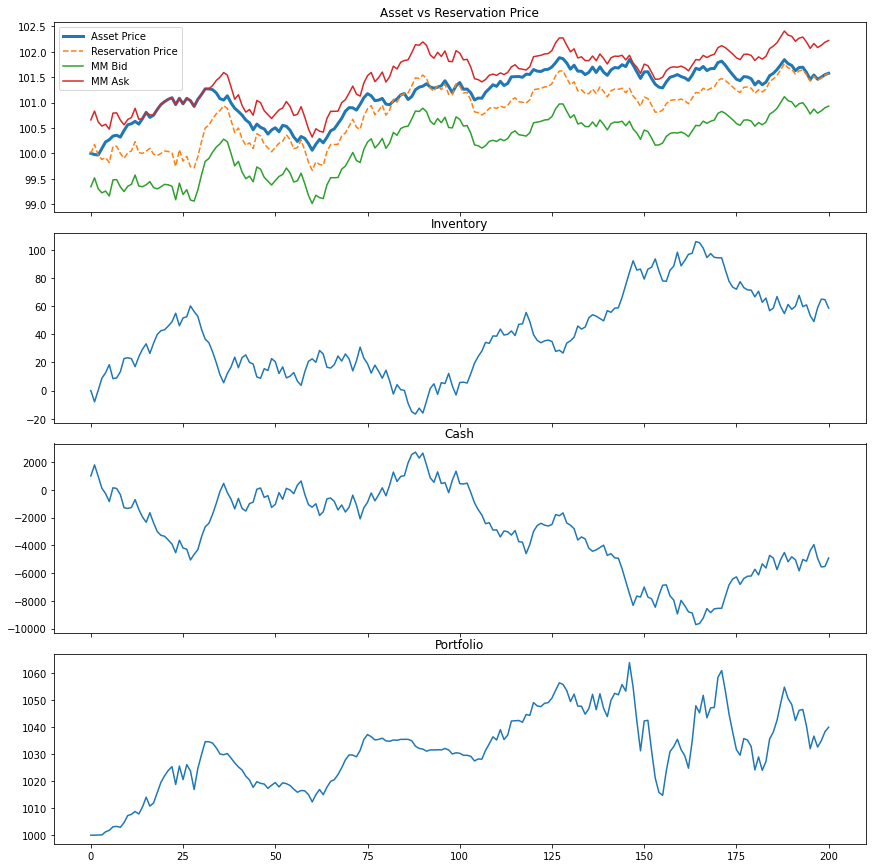

In [64]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(12,12))
f.tight_layout()

ax1.plot(mm_run.asset_prices, linewidth=3, label="Asset Price")
ax1.plot(mm_run.reservation_prices, linestyle='dashed', label="Reservation Price")
ax1.plot(mm_run.mm_bids, label="MM Bid")
ax1.plot(mm_run.mm_asks, label="MM Ask")
ax1.legend()
ax1.set_title("Asset vs Reservation Price")

ax2.plot(mm_run.inventory_snapshots, label="Inventory")
ax2.set_title("Inventory")

ax3.plot(mm_run.cash_snapshots, label="Cash")
ax3.set_title("Cash")

ax4.plot(mm_run.portfolio_snapshots, label="Portfolio")
ax4.set_title("Portfolio")